In [1]:
from src.MPOpto import *
from src.LinModel import *
from src.NLModel import *
from src.CURBD.CurbdModel import *
from src.analysis import *
from src.fling import *

%load_ext autoreload 
%autoreload 2
%matplotlib widget

In [2]:
#model = pload('/home/diya/Documents/mp_opto/picklejar/curbd_models2/curbdBioco10_bal.pickle')
model = pload('/home/diya/Documents/mp_opto/data/cu3/cu9_rates_down/curbdBioco9_1.4.pickle')

0.45908521354644205


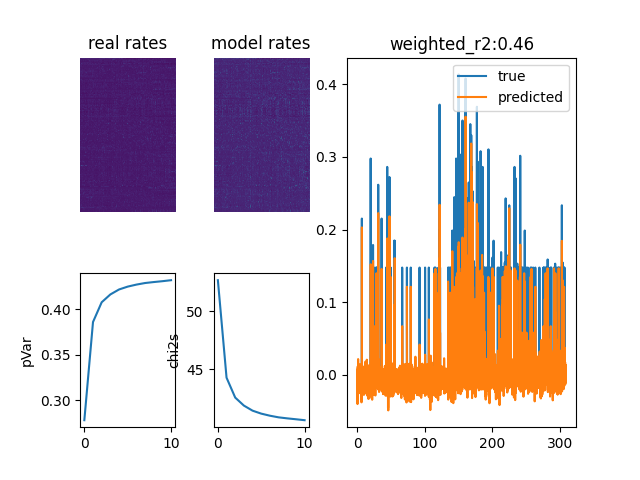

0.3952269274631145
0.3952269274631145


In [3]:
plotFit(model)
d, u = CurbdModel(model).analyze_J()
print(np.log10(d/u))

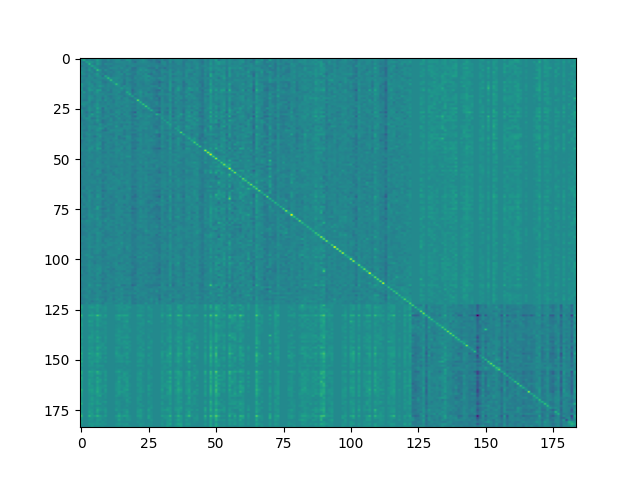

In [4]:
fig, ax = plt.subplots()
ax.imshow(model['J'], aspect='auto')

In [5]:
model['scaler'].scale_.shape

(184,)

# true

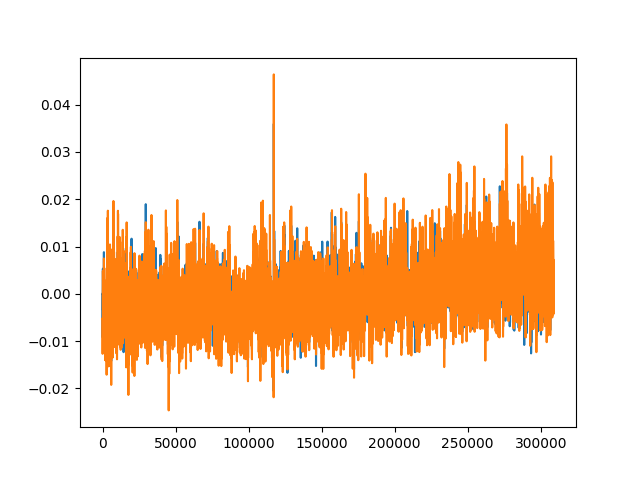

In [6]:
idx_r1 = model['regions']['region1']
idx_r2 = model['regions']['region2']
RNN = model['RNN']
up_RNN = np.average(RNN[idx_r1,:], axis=0)
down_RNN = np.average(RNN[idx_r2,:], axis=0)
fig, ax = plt.subplots()
ax.plot(up_RNN.T)
ax.plot(down_RNN.T)

In [7]:
np.sum(model['J'][idx_r1,idx_r1]) - np.sum(model['J'][idx_r2,idx_r2])

21.59179750363309

In [8]:
session = CurbdModel(model)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 329999/329999 [00:07<00:00, 46586.68it/s]


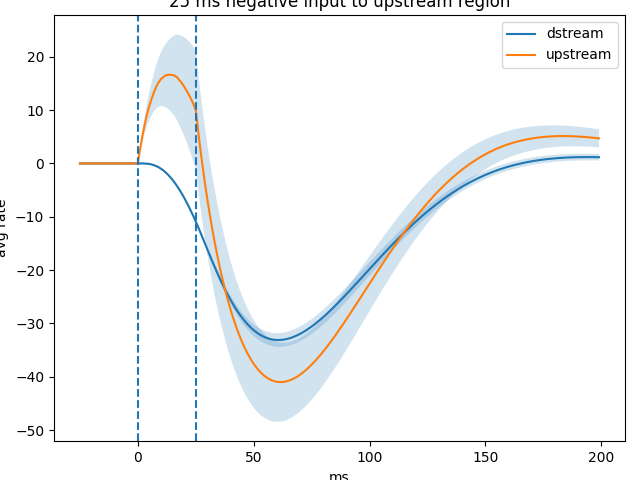

In [9]:
ampInWN=.2
optoMult = 3*ampInWN
rates, opto_logical, all_input = session.simulate_opto(t=300, stim_frequency=.4, ampInWN=ampInWN, optoMult=optoMult, sparse_stim=None, dur=.025)

Text(0, 0.5, 'rate')

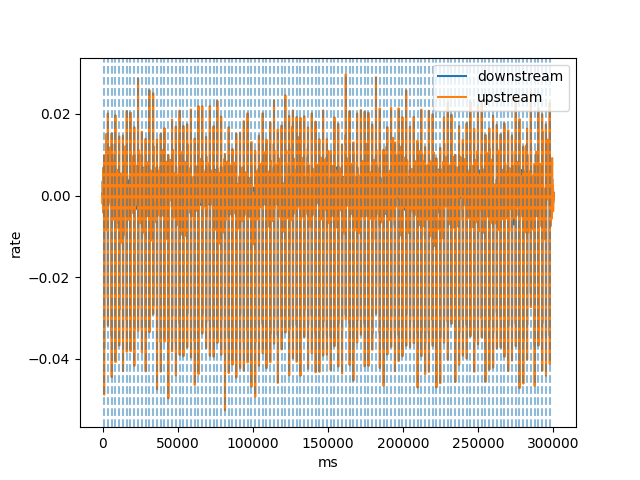

In [10]:
fig, ax = session.plot_opto(rates, opto_logical)
ax.set_xlabel('ms')
ax.set_ylabel('rate')

In [11]:
spikes = session.rates2spikes(rates, scale=False, poisson_mult=5)

In [12]:
#output = session.generate_spikedata(rates, opto_logical, spikes)
output = session.generate_ratedata(rates, spikes.T, opto_logical)

In [13]:
#pdump(output, '/home/diya/Documents/mp_opto/data/cu2/cu12_rates_down/cu12_rates_down.pickle')
pdump(output, '/home/diya/Documents/mp_opto/data/cu3/cu9_rates_down/cu9_rates_down.pickle')

In [225]:
session_path = '/home/diya/Documents/mp_opto/data/cu2/test'

In [226]:
opto_sesh = LinModel(session_path)
curbd_sesh = CurbdModel(pload(f'{session_path}/test.pickle'))

this is a rate model
finished loading curbd sim data
contains sim data already


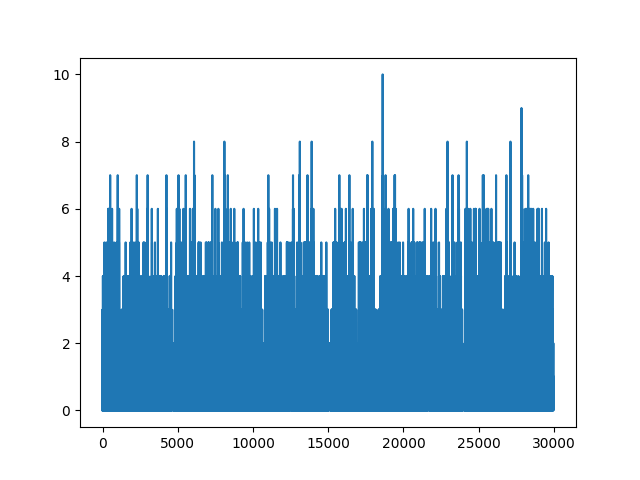

In [227]:
fig, ax = plt.subplots()
reg1, reg2= opto_sesh.binner(opto_sesh.climbing_bounds, binsize=10, concat=True)
ax.plot(reg1[:,5])

# testing activity

In [228]:
binsize=10
nlags=5
num_PCs=20
if num_PCs is None:
    num_region1 = opto_sesh.num_region1
else:
    num_region1=num_PCs

omit_lasers, _ =opto_sesh.adjustLaserBounds(pre=binsize*nlags, post=250)
just_climbs = omitBoundInBounds(opto_sesh.climbing_bounds, omit_lasers)
(X, Y), PCs = opto_sesh.generate_trainset(bounds = just_climbs, binsize=binsize, nlags=nlags, num_PCs=num_PCs)
r1_mask, r2_mask = mask_input_region(X, nlags=nlags, num_region1=num_region1)

h_ctrl = train_wiener_filter(X, Y, c=(2,6))
h2 = train_wiener_filter(X[:,r1_mask], Y ,c=(2,6))
nada = train_wiener_filter(X[:,r2_mask], Y ,c=(2,6))

opto_sesh.get_relative_drive(h_ctrl, X, nlags=nlags, num_region1=num_region1)

fitting and applyingPCA
best test:0.5120638083349983
best_c: 46415.888336127726, train_r2: 0.5146592731284351
best test:0.5089687451976488
best_c: 46415.888336127726, train_r2: 0.5124682611533623
best test:0.19303348674860518
best_c: 16681.005372000593, train_r2: 0.1972159199227974


0.7263445263705597

In [229]:
reg1_predics, reg2_predics = opto_sesh.get_region_predics(h_ctrl, X, nlags=nlags, num_region1=num_region1)

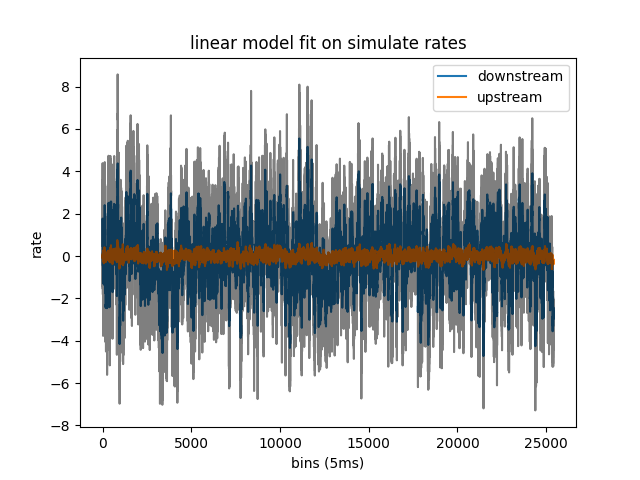

In [230]:
fig, ax = plt.subplots()
ax.set_title('linear model fit on simulate rates')
ax.plot(reg1_predics[:,0], label='downstream')
ax.plot(reg2_predics[:,0], label='upstream')
ax.set_ylabel('rate')
ax.set_xlabel('bins (5ms)')
ax.plot(Y[:,0], color='black', alpha=.5)
ax.legend()

In [231]:
laser_bounds, climb_only = curbd_sesh.adjustLaserBounds(pre=0, post=15)
d, u, decay =curbd_sesh.relative_J(bounds=laser_bounds, binsize=10)

print(np.log10((d+decay)/u))

d, u, decay =curbd_sesh.relative_J(bounds=climb_only, binsize=10)
print(np.log10((d+decay)/u))


0.14042705433689648
0.14042705433689648
0.8437001952333992
0.8437001952333992


# testing opto

In [232]:
#binsize=5
#nlags=5
#num_PCs=20
#num_region1 = num_PCs
#num_region1 = opto_sesh.num_region1

laser_bounds, _ =opto_sesh.adjustLaserBounds(pre=binsize*nlags, post=15)
sw = opto_sesh.getSWs(opto_sesh.climbing_bounds, laser_bounds, sw_weight=75, binsize=binsize, nlags=nlags)
(X, Y), PCs = opto_sesh.generate_trainset(bounds = opto_sesh.climbing_bounds, binsize=binsize, nlags=nlags, num_PCs=num_PCs)
r1_mask, r2_mask = mask_input_region(X, nlags=nlags, num_region1=num_region1)


h_laser = train_wiener_filter(X, Y, sw=sw, c=(2,6))

h2 = train_wiener_filter(X[:, r1_mask], Y , sw=sw, c=(2,6))
h3 = train_wiener_filter(X[:, r2_mask], Y, sw=sw, c=(2,6))

fitting and applyingPCA
best test:0.553925096053347
best_c: 46415.888336127726, train_r2: 0.557507612590107
best test:0.5135276641849627
best_c: 46415.888336127726, train_r2: 0.5165350725180983
best test:0.3758930741267215
best_c: 129154.96650148826, train_r2: 0.3830361198562945


In [233]:
(X_test, Y_test) = opto_sesh.generate_testset(bounds = laser_bounds, binsize=binsize, nlags=nlags, PCAObjs=PCs)
yhat = test_wiener_filter(X_test, h_laser)
print(weighted_r2(Y_test, yhat))

applying PCA
0.5356808135445404


In [234]:
reg1_predics, reg2_predics = opto_sesh.get_region_predics(h_laser, X_test, nlags=nlags, num_region1=num_region1)
#opto_sesh.get_relative_drive(h_laser, X_test, nlags=nlags, num_region1=num_region1)
opto_sesh.get_relative_drive(h_laser, X, nlags=nlags, num_region1=num_region1)

0.5385366261989055

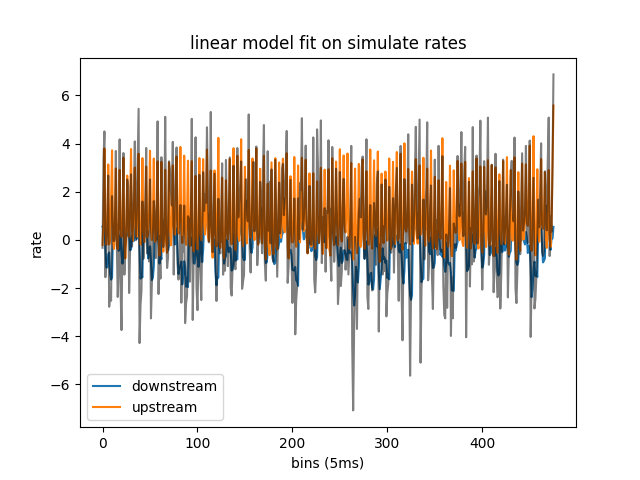

In [235]:
fig, ax = plt.subplots()
ax.set_title('linear model fit on simulate rates')
ax.plot(reg1_predics[:,0], label='downstream')
ax.plot(reg2_predics[:,0], label='upstream')
ax.set_ylabel('rate')
ax.set_xlabel('bins (5ms)')
ax.plot(Y_test[:,0], color='black', alpha=.5)
ax.legend()

In [206]:
h_laser = train_wiener_filter(X_test, Y_test, c=(2,6))
h2 = train_wiener_filter(X_test[:, r1_mask], Y_test, c=(2,6))
h3 = train_wiener_filter(X_test[:, r2_mask], Y_test, c=(2,6))

best test:0.4609533862127761
best_c: 2154.4346900318824, train_r2: 0.5985365322461117
best test:0.39817057023321545
best_c: 774.263682681127, train_r2: 0.5221151056440223
best test:0.369022131023774
best_c: 5994.8425031894085, train_r2: 0.3803505994379512


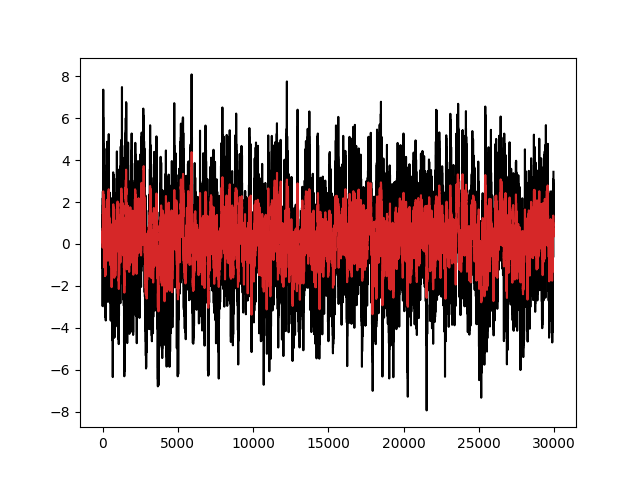

In [207]:
yhat = test_wiener_filter(X, h_laser)
fig, ax = plt.subplots()
ax.plot(Y[:,2], color='black')
ax.plot(yhat[:,2], color='tab:red')

In [30]:
curbd_sesh = CurbdModel(pload('session_path = '/home/diya/Documents/mp_opto/data/cu/cu9_rates_75'

SyntaxError: EOL while scanning string literal (2193761404.py, line 1)

In [ ]:
reg1_predics, reg2_predics = opto_sesh.get_region_predics(h_laser, X_test, nlags=nlags, num_region1=num_region1)

In [ ]:
fig, ax = plt.subplots()
ax.set_title('linear model fit on simulate rates, w/ opto')
ax.plot(reg1_predics[:,0]/5, label='downstream')
ax.plot(reg2_predics[:,0]/5, label='upstream')
ax.set_ylabel('rate')
ax.set_xlabel('bins (5ms)')
ax.plot(Y_test[:,0]/5, color='black', alpha=.5)
ax.legend()